# DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS (DCGANs)

### KAYNAKLAR

https://github.com/Oguzhanercan/GANs/blob/master/tutorial/GANs.ipynb Applied GANs

https://arxiv.org/pdf/1511.06434.pdf     Deep Convolutional Generative Adversarial Nets

http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf   Convolutional Neural Networks


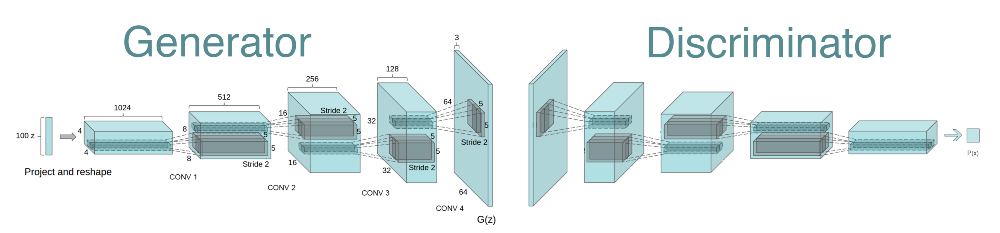

Bu notebook dahilinde görüntü verileri üreteceğiz. Deep Learning uygulamaları kapsamında görüntü verileriyle işlem yaparken CNNs mimarisi kullanılması başarı oranımızı yükseltiyor. CNNs görüntümüzdeki local patternleri yakalamada klasik fully connected neural networklerden çok daha başarılı. CNNs'in işleyişinden bahsetmeyeceğim ama kaynaklar kısmından gerekli bilgiye ulaşabilirsiniz.

DCGANs'in detayı inmeden önce GANs'in ilginç bir özelliğini inceleyelim. Bir soru ile bu ilginç özelliği değinmek gerekirse bu model supervised mı yoksa unsupervised mı ? Etiketlenmemiş verilerle beslediğimiz model bağlamında unsupervised. Loss fonksiyonumuzu düşündüğümüzde ise supervised. Supervised bir problemi unsupervised bir şekilde çözdüğümüzü söylersek yanlış olur mu ?

### DCGANs nasıl çalışır ?

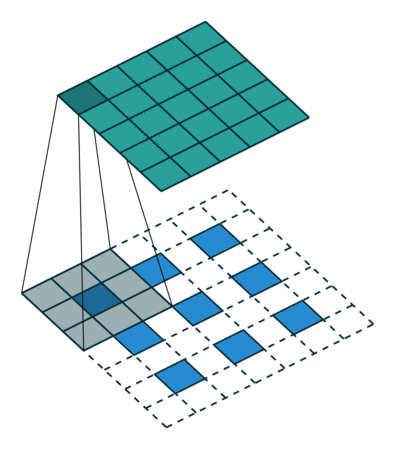

GANs'de bulunan G ve D modelleri ile devam ediyoruz. İlginçtir ki pooling işlemi uygulamıyoruz.Model D için Strided Conv kullanarak alt uzayları belirleyici bağlamlardan ( maxpooling kullansaydık en büyük değeri almış olurduk belirleyici bağlamdan kasıt budur) kurtarıp modelin öğrenmesini sağlıyoruz. Model G için ise resimde görüldüğü gibi Strided Conv uygulayarak boyut arttırmak mümkün değil.GİF'de görülen Fractional-Strided Convolutions methodu uygulanır. Mavi ile gösterilenler bizim orjinal pixellerimiz ve beyazlar ise 0 değerleri.

DCGANs makalesinde fully connected layerlardan kurtulmanın sonuçları açıklanmış. Bu layerlar yerine global average pooling kullanmak modelimizi daha stabil hale getiriyor ki modelin stabil olmaması büyük bir problem yaratıyor fakat modelin yakınsama hızını yavaşlatıyor.

Batchnormalization modelin stabil çalışması için önemli bir aşama. Batchnormalization derin ağlarda gradient hesaplamarında hız sağlıyor. Daha önemlisi DCGANs'de model G'nin ürettiği tüm sampleların tek bir noktaya evrilmesini engelliyor. Batchnorm'u tüm layerlara uygulamanın denemeler sonucu modelin stabilliğini bozduğu yönünde sonuçlar oluşturuyor. Model G'nin output layerına ve model D'nin input layerına uygulanmaması bu problemi çözüyor.

Aktivasyon fonksiyonu olarak model G'de output layerı hariç ReLU , output layerında ise tanh fonksiyonları kullanılıyor.Modelin daha hızlı eğitilmesi ve renk uzaylarını daha iyi kavraması ile sonuçlanıyor. Model D'de ise Leaky ReLU kullanılıyor. Özellikle yüksek çözünürlüklü görüntülerde daha yüksek başarı elde ediliyor.

# DCGANs İmplementasyonu

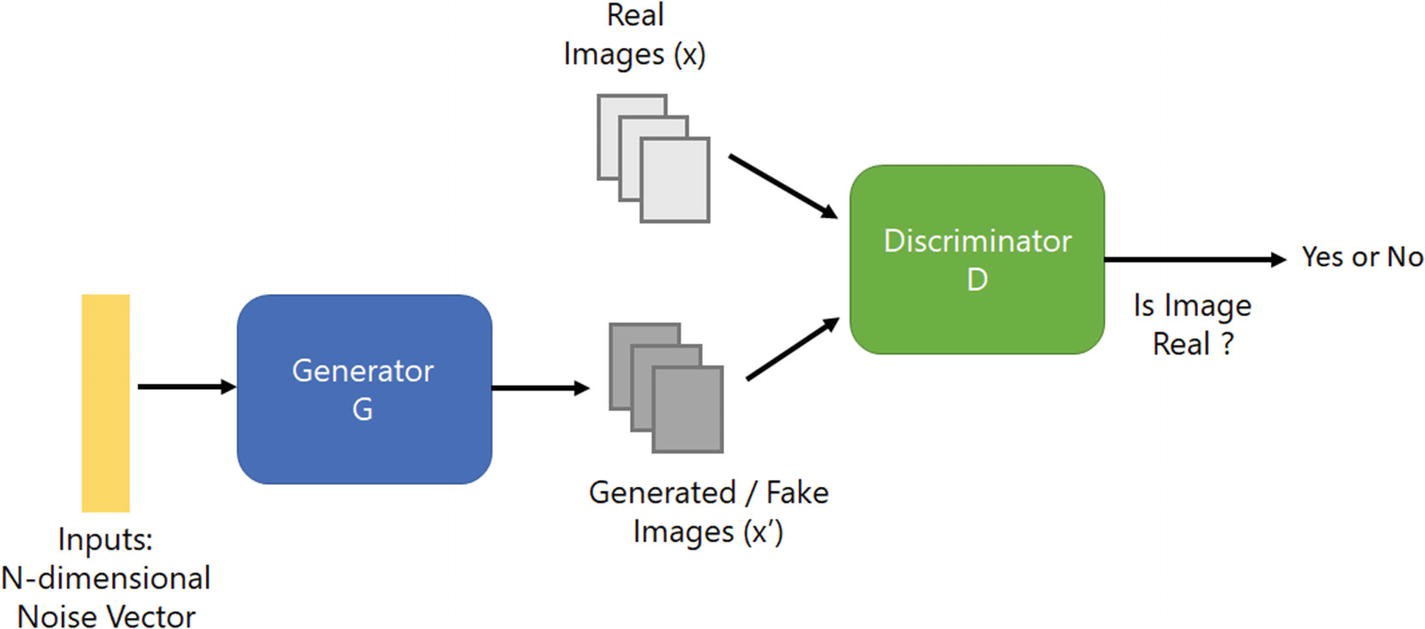

### Kütüphaneleri İmport edelim


In [2]:
%matplotlib inline
import numpy as np # Matris işlemleri
import torch 
import matplotlib.pyplot as plt # Görselleştirme aracı
import torchvision
import torch.nn as nn # Neural network yapısında kullanılan yapıları yaratmamızı sağlar.
import torch.nn.functional as F # Neural network yapısında kullanılan yapıları yaratmamızı sağlar.
import torch.optim as optim # Optimizerları kullanmamıza yarar.
from torchvision import datasets # Datasetimizi indirmeye yarar.
import torchvision.transforms as transforms # Datamızı tenosrlere çevirmeye yarar

### DATA

GANs isimli notebookumda MNIST gibi basit bir problem seçmiştik çünkü klasik GANs yapısındaki fully connected layerlar resim verilerinde çok başarılı değil. Bu yapıda Conv layerlar kullanacağımız için daha yüksek potansiyelimizi kullanarak insan yüzü üretelim. Datasetimiz CelebFaces Attributes Dataset (CelebA).

In [19]:
#num_workers train sürecinde modeli eğitirken forward ve backward propagation sırasında 
#datamızdan kaç batch'i GPU'ya taşıyacağının miktarıdır. Doğru rakam modelimizi hızlandırır.
num_workers = 1 # Deneyimlerim kendi GPU'm için en iyi sonucu 1'in verdiği yönünde
# Her bir batch'de kaç sample olacağını tanımlıyoruz.
batch_size = 128

# Paperda incelediğimizde datada celebA dataseti kullanılmış ve 64x64 olacak şekilde crop edilmiş.. 
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# Datamızı indiriyoruz.
train_data = torchvision.datasets.ImageFolder(root="C:/Users/bilgisayar/Desktop/Ml_implementations/Intro2ML/data/celebA", transform=transform
                           )


#train_data = datasets.CIFAR10(root='./data', train=True,
 #                                       download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle = True num_workers = num_workers)

In [20]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([128, 3, 64, 64])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


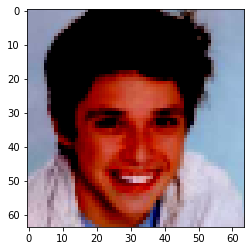

In [21]:
plt.imshow(np.transpose(images[9], (1, 2, 0)))

## Modellerimizi tanımlayalım 

DCGANs paperında bahsi geçen notebookun başındaki görseldeki modeli kodlayacağız.

### Discriminator

Klasik GANs'den (Goodfellow's GANs) farklı olarak fully connected layerlar yerine Conv katmanlar ile model mimarimizi kuruyoruz. Batch Norm ile modelimizin stabil çalışmasını sağlıyoruz fakat ilk layera uygulamıyoruz sebebi ise amacımız olan modelin stabil olması durumuna ters düşen sonuçlar doğurması. Paperda (DCGANs) önerildiği gibi aktivasyon fonksiyonu olarak Leaky ReLU kullanıyoruz. Binary olasılık değeri hesaplayacağımız için son çıktımızı Sigmoide fonksiyonuna sokuyoruz.
Tüm hyperparameterleri paperda bahsedildiği gibi ayarlıyoruz.

In [22]:
class discriminator(nn.Module):
    def __init__(self,num_channels): # num_channels datamızda kaç kanallı (RGB renkli resimler için 3)
        #hyper_conv conv layerlarda kullanacağımız conv layerlardaki filtre sayısı için bir hyperparameter
        super(discriminator,self).__init__()
        self.modeld = nn.Sequential(
            # 3*64*64
            nn.Conv2d(num_channels,128,kernel_size = 4,stride =2 ,padding = 1),
            nn.LeakyReLU(0.2),
            # 128*32*32
            nn.Conv2d(128,256,kernel_size = 5,stride =2 ,padding = 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 256*16*16
            nn.Conv2d(256,512,kernel_size = 5,stride =2 ,padding = 2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 512*8*8
            nn.Conv2d(512,1024,kernel_size = 5,stride =2 ,padding = 2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            # 1024*4*4
            nn.Conv2d(1024,1,kernel_size = 4,stride =1 ,padding = 0),
            # 1*1*1
            nn.Sigmoid()
        )
        
        
        
        
        
        
        
    def forward(self,x):
        return self.modeld(x)

### Generator

tek boyutlu noise olarak adlandıracağımız bir arrayden bir resim üreteğiz. Fractional strided convolution ile resmimizin boyutu büyütüyoruz. Son katman hariç bach norm uygulayarak stabil çalışmasını sağlıyoruz. Paperda önerildiği gibi ReLU aktivasyon fonksiyonu kullanıyoruz.

In [46]:
class generator(nn.Module):
    def __init__(self,noise_shape,num_channels):
        super(generator,self).__init__()
        self.modelg = nn.Sequential(
            nn.ConvTranspose2d( noise_shape, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            # 1024*4*4
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512*8*8
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 216*16*16
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128*32*32
            nn.ConvTranspose2d( 128, num_channels,4, 2, 1, bias=False),
            # 3*64*64
            nn.Tanh()
            # 3*64*64
        )
        
    def forward(self,x):
        return self.modelg(x)

### Model hyperparameters

In [48]:
lr = 0.0002 # learning rate
image_size = 64 # 32*32
num_channels = 3 # RGB
noise_shape = 100 # random noise vektörünün boyutu
num_epochs = 1 # epoch sayısı

GPU'da çalışmak için device tanımlayalım.

In [49]:
device = torch.device("cuda")

Modellerimizi oluşturalım.

In [50]:
modelG = generator(noise_shape,num_channels).to(device)

In [51]:
modelD = discriminator(num_channels).to(device)

Optimizerlarımızı tanımlayalım. Modelleri ayrı eğiteceğimiz için 2 adet oluşturacağız.

In [52]:
optimizerD = optim.Adam(modelD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=lr, betas=(0.5, 0.999))

Loss fonksiyonumuzu tanımlayalım.

In [53]:
criterion = nn.BCELoss()

Labellarımızı oluşturalım. Gerçek resimler için 1 ,sahteler için 0 kullanacağız.

In [54]:
real_label = 1
fake_label = 0


In [55]:
fixed_noise = torch.randn(128,noise_shape,1,1).to(device) #128 batch size , 100x1x1 lik .

In [56]:
step = 0

## Model Train

In [57]:
samples = [] # ürettiğimiz resimleri depolamak için bir liste 



for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        batch_size = data.shape[0] # data.shape[0] == 128

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        modelD.zero_grad() # Gradleri 0'lıyoruz. Sıfırlamazsak her bir iterasyonda kümülatif şekilde artar yanlış sonuç verir.
        label = (torch.ones(batch_size) * 0.9).to(device)# 0.9 ile çarptık model D'nin kendine çok güvenmemesi için.
        output = modelD(data).view(-1) # olasılık değerlerini vektör halinde depola
        lossD_real = criterion(output, label) # loss fonksiyonuna sok
        D_x = output.mean().item() # D_x ' e batch ortalamasını kaydet

        noise = torch.randn(batch_size, noise_shape, 1, 1).to(device) # noise üret 128*100*1*1
        fake = modelG(noise) # forward P
        label = (torch.ones(batch_size) * 0.1).to(device) # labelları üret 0.1 ile çarpmak model D'nin kendine çok güvenmemesi için.

        output = modelD(fake.detach()).view(-1)# Olasılık değerlerini vektör haline getiriyoruz.
        #.detach() fonksiyonu ile fake fonksiyonuyla aynı memoryi kullanan ve grad gerektirmeyen bir tensor yaratır.
        #memoryde fazla yer kaplamaz ve işlem hızı artar.
        
        #Loss hesaplayıp backward prop ile train edelim..
        lossD_fake = criterion(output, label)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator: max log(D(G(z)))
        modelG.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = modelD(fake).reshape(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Print
        if batch_idx % 100 == 0:
            step += 1
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f} D(x): {D_x:.4f}"
            )
            modelG.eval()
            with torch.no_grad():
                
                samples_z = modelG(fixed_noise)
                samples.append(samples_z)
    
            modelG.train() # Train mode

Epoch [0/1] Batch 0/1583                   Loss D: 1.4007, loss G: 9.1034 D(x): 0.4695
Epoch [0/1] Batch 100/1583                   Loss D: 0.8010, loss G: 2.7859 D(x): 0.7782
Epoch [0/1] Batch 200/1583                   Loss D: 1.1480, loss G: 1.5701 D(x): 0.5733
Epoch [0/1] Batch 300/1583                   Loss D: 1.0443, loss G: 1.6359 D(x): 0.6592
Epoch [0/1] Batch 400/1583                   Loss D: 1.2229, loss G: 1.2256 D(x): 0.4704
Epoch [0/1] Batch 500/1583                   Loss D: 2.6155, loss G: 1.6737 D(x): 0.1093
Epoch [0/1] Batch 600/1583                   Loss D: 1.0478, loss G: 3.0756 D(x): 0.7627
Epoch [0/1] Batch 700/1583                   Loss D: 1.0023, loss G: 1.8593 D(x): 0.6471
Epoch [0/1] Batch 800/1583                   Loss D: 0.9964, loss G: 2.5778 D(x): 0.7587
Epoch [0/1] Batch 900/1583                   Loss D: 1.1204, loss G: 1.2124 D(x): 0.5049
Epoch [0/1] Batch 1000/1583                   Loss D: 0.9323, loss G: 1.9807 D(x): 0.6914
Epoch [0/1] Batch 1100

In [97]:
samples[1].shape

torch.Size([128, 3, 64, 64])

In [98]:
len(samples)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


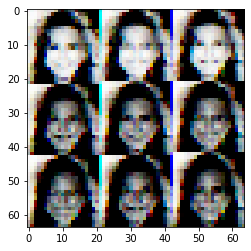

In [120]:
plt.imshow(samples[15][0].cpu().view(64,64,3))

In [124]:
modelG_save = torch.save(modelG.state_dict(), "modelG_saved_dcgans.pth")
modelD_save = torch.save(modelD.state_dict(), "modelD_saved_dcgans.pth")